In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import cv2
import sys
import os
import glob

sys.path.insert(0, '..')

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from MulticoreTSNE import MulticoreTSNE as MTSNE

colors = [ 'firebrick', 'olivedrab', 'blueviolet', 'goldenrod', 'lightsalmon' ]
labels = ['G3', 'G4', 'G5', 'BN', 'ST']

In [3]:
# from fcn8s import Inference
# SNAPSHOT = '../fcn8s/10x/snapshots/fcn.ckpt-82585'
# from densenet_small import Inference
# SNAPSHOT = '../densenet_small/10x/snapshots/densenet.ckpt-30845'; MODEL_NAME='DensenetSmall'
# from densenet import Inference
# SNAPSHOT = '../densenet/10x/snapshots/densenet.ckpt-55800'; MODEL_NAME='Densenet'
from unet import Inference
SNAPSHOT = '../unet/10x/snapshots/unet.ckpt-49600'; MODEL_NAME='UNet'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Inference(sess=sess, x_dims = [256, 256, 3])
model.restore(SNAPSHOT)

Setting up unet in inference mode
DenseNet Model
Non-linearity: <function selu at 0x7f5a4945b1b8>
	 x_in (?, 256, 256, 3)
down1_1 (?, 256, 256, 64)
down2_1 (?, 128, 128, 128)
down3_1 (?, 64, 64, 256)
down4_1 (?, 32, 32, 512)
down5_1 (?, 16, 16, 1024)
concat4 (?, 32, 32, 1024)
up4_2 (?, 32, 32, 512)
concat3 (?, 64, 64, 512)
up3_2 (?, 64, 64, 256)
concat2 (?, 128, 128, 256)
up2_2 (?, 128, 128, 128)
concat1 (?, 256, 256, 128)
up1_2 (?, 256, 256, 64)
y_hat (?, 256, 256, 5)
Model output y_hat: (?, 256, 256, 5)
Restoring from ../unet/10x/snapshots/unet.ckpt-49600
INFO:tensorflow:Restoring parameters from ../unet/10x/snapshots/unet.ckpt-49600
Success!


## Single images; close to x-space

In [4]:
# Initialize data structures
jpg_list = sorted(glob.glob('../data/train_jpg/*.jpg'))
mask_list = sorted(glob.glob('../data/train_mask/*.png'))
img = cv2.imread(jpg_list[0])[:,:,::-1]
img = img[128:640, 128:640, :]
img = cv2.resize(img, dsize=(0,0), fx=0.5, fy=0.5)
img = np.expand_dims(img, 0)

mask = cv2.imread(mask_list[0], -1)
mask = mask[128:640, 128:640]
mask = cv2.resize(mask, dsize=(0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)

z_dict = {}
z_shape_dict = {}
y_dict = {}
y_shape_dict = {}
x_dict = {}

for key, op in model.intermediate_ops.items():
    ret = sess.run(op, {model.x_in: img, model.keep_prob: 1.0})

    retshape = ret.shape
    print(retshape)
    zshape = [retshape[1] * retshape[2], retshape[-1]]
    z_dict[key] = np.empty(shape=(0, retshape[-1]))
    x_dict[key] = np.empty(shape=(0, retshape[-1]))
    z_shape_dict[key] = zshape
    y_dict[key] = np.empty(shape=(0, 1), dtype=np.int)
    y_shape_dict[key] = [retshape[1], retshape[2]]
    
for key in sorted(z_dict.keys()):
    print(key, y_dict[key], z_dict[key], z_shape_dict[key], y_shape_dict[key])

(1, 64, 64, 256)
(1, 128, 128, 128)
(1, 256, 256, 64)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 256, 256, 5)
(1, 32, 32, 512)
(1, 256, 256, 64)
(1, 128, 128, 128)
01. Down1 [] [] [65536, 64] [256, 256]
02. Down2 [] [] [16384, 128] [128, 128]
03. Down3 [] [] [4096, 256] [64, 64]
04. Down4 [] [] [1024, 512] [32, 32]
05. Up4 [] [] [1024, 512] [32, 32]
06. Up3 [] [] [4096, 256] [64, 64]
07. Up2 [] [] [16384, 128] [128, 128]
08. Up1 [] [] [65536, 64] [256, 256]
09. y_hat [] [] [65536, 5] [256, 256]


In [5]:
# Populate dicts
jpg_list = sorted(glob.glob('../data/val_jpg/*.jpg'))
mask_list = sorted(glob.glob('../data/val_mask/*.png'))

x0 = 128
y0 = 128

n = 25

imgs = zip(jpg_list, mask_list)
np.random.shuffle(imgs)

for jpg, mask in imgs[:n]:

    x = cv2.imread(jpg, -1)[:,:,::-1]
    y = cv2.imread(mask, -1)
    y_ = y[x0:x0+512, y0:y0+512]
    x_ = x[x0:x0+512, y0:y0+512]
    x_ = cv2.resize(x_, dsize=(0,0), fx=0.5, fy=0.5)
    x_ = x_ * (2/255.) - 1.
    x_ = np.expand_dims(x_, 0)

    for key, op in model.intermediate_ops.items():
        ret = sess.run(op,  feed_dict={model.x_in: x_, model.keep_prob: 1.0})
        op_shape = z_shape_dict[key]
        ret_reshape = ret.reshape(op_shape)
        z_dict[key] = np.concatenate([z_dict[key], ret_reshape], axis=0)
        
        y_resize = cv2.resize(y_, dsize=tuple(y_shape_dict[key]), interpolation=cv2.INTER_NEAREST)
        y_resize = y_resize.reshape([np.prod(y_shape_dict[key]), 1]).astype(np.int)
        y_dict[key] = np.concatenate([y_dict[key], y_resize], axis=0)
        
for key in z_dict.keys():
    print(key, '\t', y_dict[key].shape, z_dict[key].shape, np.unique(y_dict[key]))


03. Down3 	 (102400, 1) (102400, 256) [0 1 2 3 4]
04. Down4 	 (25600, 1) (25600, 512) [0 1 2 3 4]
09. y_hat 	 (1638400, 1) (1638400, 5) [0 1 2 3 4]
08. Up1 	 (1638400, 1) (1638400, 64) [0 1 2 3 4]
01. Down1 	 (1638400, 1) (1638400, 64) [0 1 2 3 4]
07. Up2 	 (409600, 1) (409600, 128) [0 1 2 3 4]
06. Up3 	 (102400, 1) (102400, 256) [0 1 2 3 4]
02. Down2 	 (409600, 1) (409600, 128) [0 1 2 3 4]
05. Up4 	 (25600, 1) (25600, 512) [0 1 2 3 4]


In [6]:
# Gather alike classes and project each layer 
y_plot = []
n_sample = 1000

for k in range(5):
    
    for key in z_dict.keys():
        y_key = y_dict[key]
        z_key = z_dict[key]
        x_key = x_dict[key]
        
        z_key_class = z_key[np.squeeze(y_key) == k, :]
        n_z = z_key_class.shape[0]
        idxs = np.arange(n_z)
        z_choice = z_key_class[np.random.choice(idxs, n_sample), :]
        x_key = np.concatenate([x_key, z_choice], axis=0)
        x_dict[key] = x_key
        
    y_plot += [k]*n_sample
        

manifold_dict = {}
manifolder = MTSNE(n_components=2, n_jobs=8)
for key, vals in sorted(x_dict.items()):
    print(key, '\t', vals.shape)

    pr0 = manifolder.fit_transform(vals)
    manifold_dict[key] = pr0


01. Down1 	 (5000, 64)
02. Down2 	 (5000, 128)
03. Down3 	 (5000, 256)
04. Down4 	 (5000, 512)
05. Up4 	 (5000, 512)
06. Up3 	 (5000, 256)
07. Up2 	 (5000, 128)
08. Up1 	 (5000, 64)
09. y_hat 	 (5000, 5)


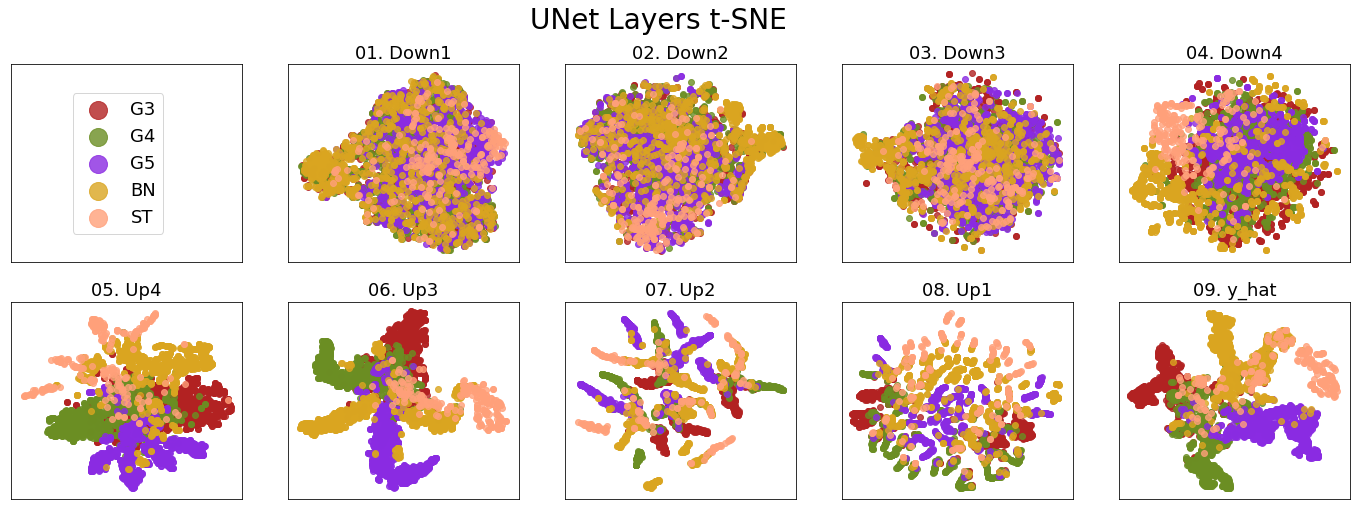

In [22]:
n_cols = len(manifold_dict.keys()) / 2 + (len(manifold_dict.keys()) % 2)
fig, axs = plt.subplots(2, n_cols, figsize=(24, 8))
axs = axs.flatten()

if (len(manifold_dict.keys())) % 2 > 0:
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    axs = axs[1:]
    
for k in range(5):
    idxs = np.squeeze(np.where(np.asarray(y_plot)==k))
    if k == 4:
        idxs = np.random.choice(idxs, 250)
        
    for key, ax in zip(sorted(manifold_dict.keys()), axs):
        xs = manifold_dict[key][idxs, 0]
        ys = manifold_dict[key][idxs, 1]
        
        sns.regplot(xs, ys, fit_reg=False, color=colors[k], label=labels[k], ax=ax)
        ax.set_title(key, fontsize=18)
        ax.set_yticks([])
        ax.set_xticks([])
        
axs[0].legend(markerscale=3., bbox_to_anchor=(-0.5, 0.9), fontsize=18)
plt.suptitle('{} Layers t-SNE'.format(MODEL_NAME), fontsize=28)
plt.savefig('/home/nathan/Dropbox/_papers/gleason_grade/{}_layers_tsne.pdf'.format(MODEL_NAME), bbox_inches='tight')